In [0]:
file_path = "hive_metastore.default.sunspots_monthly_mean"
import pandas as pd

# Read the data from Hive table
df = spark.read.option("header", "false").option("sep", ";").table(file_path)

# Convert to Pandas DataFrame for displaying the first few rows
pandas_df = df.toPandas()

# Display the first few rows
display(pandas_df.head())

1749;01;1749.042; 96.7; -1.0; -1;1
1749;02;1749.123; 104.3; -1.0; -1;1
1749;03;1749.204; 116.7; -1.0; -1;1
1749;04;1749.288; 92.8; -1.0; -1;1
1749;05;1749.371; 141.7; -1.0; -1;1
1749;06;1749.455; 139.2; -1.0; -1;1


In [0]:
# Assuming the data is in the first (and only) column
# Split the semicolon-separated values into new columns
column_names = ["Year", "Month", "Date_Fraction", "Sunspot_Mean", "Sunspot_StdDev", "Observations", "Marker"]

# Split the first column based on semicolon and assign to new columns
pandas_df[column_names] = pandas_df.iloc[:, 0].str.split(';', expand=True)

# Drop the original raw data column (the first column)
pandas_df = pandas_df.drop(columns=[pandas_df.columns[0]])

# Display the updated DataFrame
display(pandas_df.head())

# Convert columns to their appropriate data types
pandas_df["Year"] = pandas_df["Year"].astype(int)
pandas_df["Month"] = pandas_df["Month"].astype(int)
pandas_df["Date_Fraction"] = pandas_df["Date_Fraction"].astype(float)
pandas_df["Sunspot_Mean"] = pandas_df["Sunspot_Mean"].astype(float)
pandas_df["Sunspot_StdDev"] = pandas_df["Sunspot_StdDev"].astype(float)
pandas_df["Observations"] = pandas_df["Observations"].astype(int)
pandas_df["Marker"] = pandas_df["Marker"].astype(int)

# Display the DataFrame with updated data types
display(pandas_df.head())

# Check the data types
print(pandas_df.dtypes)

# Display summary statistics
display(pandas_df.describe())


Year,Month,Date_Fraction,Sunspot_Mean,Sunspot_StdDev,Observations,Marker
1749,02,1749.123,104.3,-1.0,-1,1
1749,03,1749.204,116.7,-1.0,-1,1
1749,04,1749.288,92.8,-1.0,-1,1
1749,05,1749.371,141.7,-1.0,-1,1
1749,06,1749.455,139.2,-1.0,-1,1


Year,Month,Date_Fraction,Sunspot_Mean,Sunspot_StdDev,Observations,Marker
1749,2,1749.123,104.3,-1.0,-1,1
1749,3,1749.204,116.7,-1.0,-1,1
1749,4,1749.288,92.8,-1.0,-1,1
1749,5,1749.371,141.7,-1.0,-1,1
1749,6,1749.455,139.2,-1.0,-1,1


Year                int64
Month               int64
Date_Fraction     float64
Sunspot_Mean      float64
Sunspot_StdDev    float64
Observations        int64
Marker              int64
dtype: object


Year,Month,Date_Fraction,Sunspot_Mean,Sunspot_StdDev,Observations,Marker
3304.0,3304.0,3304.0,3304.0,3304.0,3304.0,3304.0
1886.2503026634383,6.49636803874092,1886.7479915254237,81.84552058111379,5.6627723970944315,118.29449152542372,0.9984866828087167
79.49439835722904,3.452280830936834,79.49389067490213,67.65883243397697,5.318689620659309,251.1843616712881,0.0388778154410408
1749.0,1.0,1749.123,0.0,-1.0,-1.0,0.0
1817.0,3.0,1817.9370000000001,24.1,-1.0,-1.0,1.0
1886.0,6.0,1886.7485000000001,67.75,5.4,30.0,1.0
1955.0,9.0,1955.55925,122.525,9.5,31.0,1.0
2024.0,12.0,2024.373,398.2,29.4,1587.0,1.0


In [0]:
# Filter definitive data
df_definitive = pandas_df[pandas_df["Marker"] == 1].reset_index(drop=True)


In [0]:
# Create a Date column
df_definitive['Date'] = pd.to_datetime(df_definitive[['Year', 'Month']].assign(Day=1))

# Set Date as index
df_definitive.set_index('Date', inplace=True)

# Select the Sunspot_Mean column
sunspot_data = df_definitive[['Sunspot_Mean']]

# Display the first few rows
sunspot_data.head()


,Sunspot_Mean
Date,
1749-02-01,104.3
1749-03-01,116.7
1749-04-01,92.8
1749-05-01,141.7
1749-06-01,139.2


In [0]:
# Normalize the "Sunspot_Mean" values to a range suitable for training.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sunspot_data)

# Display the first few scaled values
scaled_data[:5]


array([[0.26192868],
       [0.29306881],
       [0.23304872],
       [0.35585133],
       [0.34957308]])

In [0]:
# Create input-output pairs for the LSTM model.
import numpy as np

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 60  # e.g., using 60 months (5 years) of data to predict the next month
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and test sets
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Display the shapes of the training and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2591, 60, 1), (648, 60, 1), (2591, 1), (648, 1))

In [0]:
# Defin the LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


2024-06-30 14:45:15.145591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/databricks/python/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [0]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0189 - val_loss: 0.0043
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0056 - val_loss: 0.0041
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 5/50
[

*** WARNING: max output size exceeded, skipping output. ***

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 47/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0042 - val_loss: 0.0031
Epoch 48/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 49/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 50/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0043 - val_loss: 0.0031


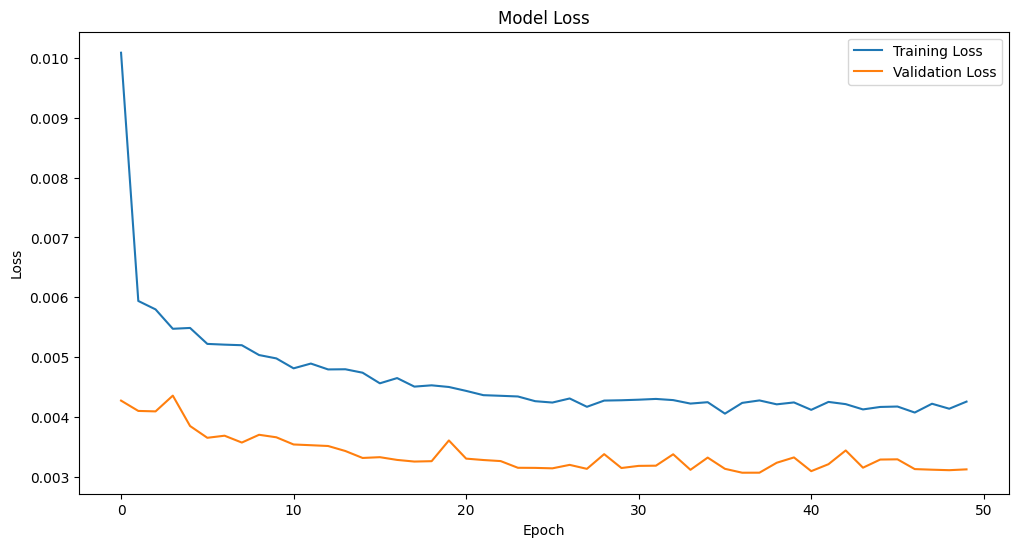

In [0]:
# Visualize training performance
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
